***
# Exploring Popular Names in the US from 2000 till 2019 
***

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-colorblind')

In [2]:
from wordcloud import WordCloud, get_single_color_func

## Reading in the scraped data

In [3]:
df = pd.read_csv('usa_top_names.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193800 entries, 0 to 193799
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  193800 non-null  int64 
 1   rank        193800 non-null  int64 
 2   name        193800 non-null  object
 3   num         193800 non-null  object
 4   year        193800 non-null  int64 
 5   state       193800 non-null  object
 6   gender      193800 non-null  object
dtypes: int64(3), object(4)
memory usage: 10.4+ MB


In [5]:
df.head()

,Unnamed: 0,rank,name,num,year,state,gender
0,0,1,William,655,2000,Alabama,male
1,1,2,Jacob,613,2000,Alabama,male
2,2,3,Joshua,503,2000,Alabama,male
3,3,4,Christopher,452,2000,Alabama,male
4,4,5,Michael,452,2000,Alabama,male


<font color=red>**Note:**</font> 
- The first column is not needed and is the index of the original dataframe
- There 100 names for each gender, each state and each year.
- The data spans names from 2000 to 2018.
- There are names for each of the 51 states in the US.

## Data Preprocessing

**Removing unnecessary features**

In [6]:
df = df.iloc[:,1:]

**Converting each feature to its appropriate data type**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193800 entries, 0 to 193799
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rank    193800 non-null  int64 
 1   name    193800 non-null  object
 2   num     193800 non-null  object
 3   year    193800 non-null  int64 
 4   state   193800 non-null  object
 5   gender  193800 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.9+ MB


<font color=red>**Note:**</font> 
- If we try to convert the 'num' feature into int64 we get a ValueError because there is a ',' character that separates the thousands place in larger numbers.
- This has to be removed so that the feature values can be converted to int64

In [8]:
# Using string replace() function to replace ',' with a blank
df['num'] = df['num'].apply(lambda x: int(x.replace(',','')) if ',' in x else int(x))

# Converting names and states to lowercase

df['name'] = df['name'].apply(lambda x: x.lower())
df['state'] = df['state'].apply(lambda x: x.lower())

# Adding a check column which would be helpful in later analysis
df['chk'] = np.ones(df.shape[0])

**Reshuffling the features to get the label 'gender' at the end of the dataframe**

In [9]:
df = df[['year','state','rank','name','num','gender', 'chk']]

## Exploratory Data Analysis

### 1. Top 5 popular baby name across all states over the years

**Defining class for grouping male and female names under different colors for wordcloud**

In [10]:
class gender_color_func(object):
    """Create a color function object that assigns certain colors
       to names that fall under each gender category 
       based on the color to words mapping
    
    """

    def __init__(self, color_to_words):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word)

**Helper function to plot wordcloud**

In [11]:
def names_wordcloud(data, max_words, background, title = None):
    
    """Word cloud genertor for the string of names
    as input"""
    
    top_names = dict(data.name.value_counts().sort_values())
    
    color_to_names = {'deepskyblue':data.loc[data.gender=='male'].name.tolist(),
                      'magenta':data.loc[data.gender=='female'].name.tolist() }
    grouped_color_func = gender_color_func(color_to_names)
    
    
    wordcloud = WordCloud(
        background_color = background,
        max_font_size = 40,
        max_words = max_words, 
        scale = 3,
        random_state = 42,
        contour_width=2
    ).generate_from_frequencies(top_names)

    fig = plt.figure(1, figsize = (15, 6))
    plt.axis('off')
    
    if title: 
        fig.suptitle(title, fontsize = 14)
        
    wordcloud.recolor(color_func=grouped_color_func)
    plt.imshow(wordcloud)
    
    plt.show()

**Selecting Top 5 names across all states and all years**

In [12]:
data = df.loc[df['rank']<=5]

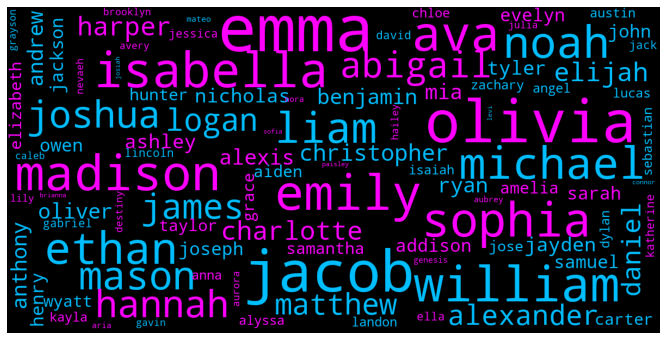

In [13]:
names_wordcloud(data, 100, 'black')

<font color=blue>**Observations:**</font>
- When we look at the top 5 baby names over the past 18 years, we see that Jacob and William are the most often chosen male names across the US.
- Emma and Olivia are the most often chosen female names across the US

### 2. 50 most and least popular names across all states over the past 19 years

In [14]:
names_states = pd.pivot_table(df, 
                              index=['gender','name'], 
                              columns='state', 
                              values='chk', 
                              aggfunc=np.sum).fillna(0)

In [15]:
# Calculating the average number of times a name occured over 19 years, across all states

names_states['freq'] = np.round(names_states.sum(axis=1)/(51), 2)

In [16]:
males = names_states.loc['male']
females = names_states.loc['female']

**50 most common names across america**

In [17]:
most_common_male_names = males.sort_values('freq', ascending=False).iloc[0:50,:-1]
most_common_female_names = females.sort_values('freq', ascending=False).iloc[0:50,:-1]

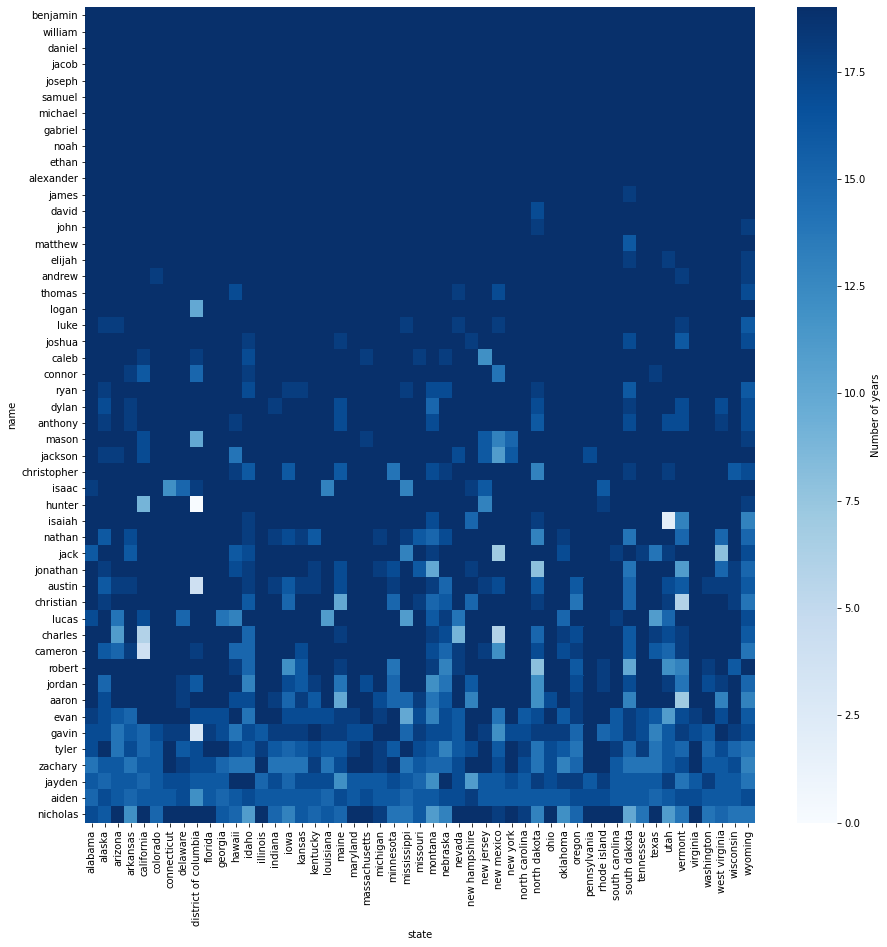

In [18]:
fig,ax = plt.subplots(figsize=[15,15])
#ax.set_title('Top 50 male names across the US over the past 19 years')
sns.heatmap(most_common_male_names,cmap='Blues', vmin=0, vmax=19, cbar_kws={'label':'Number of years'})
plt.show()

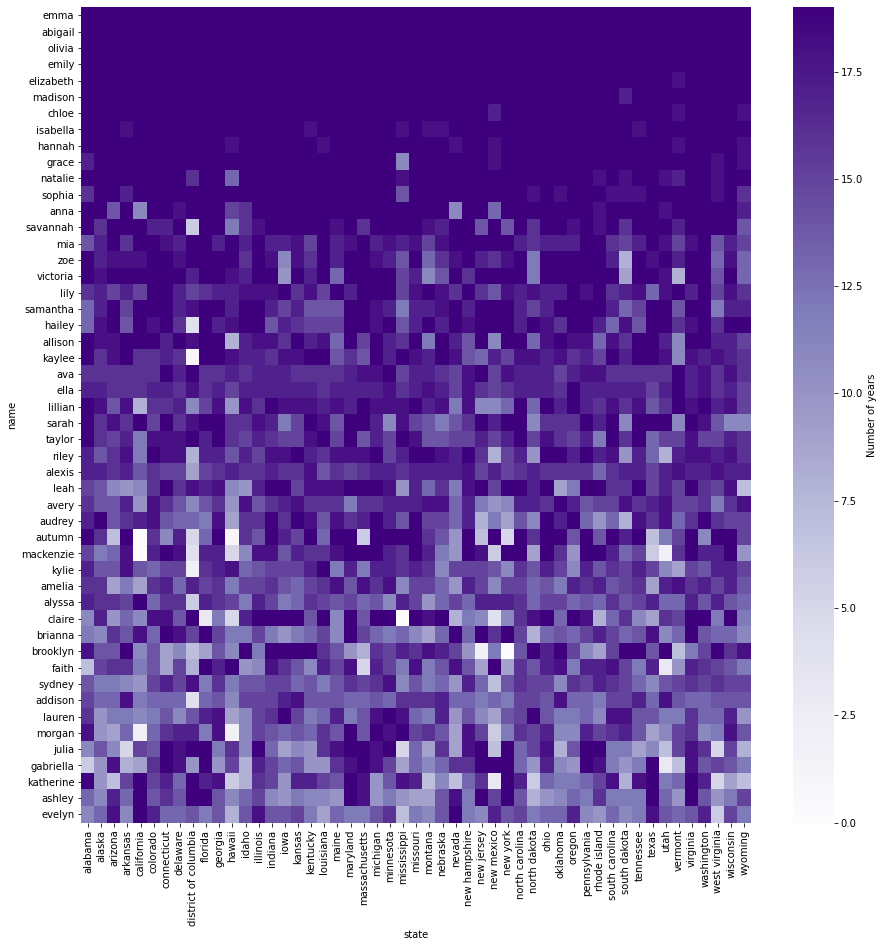

In [19]:
fig,ax = plt.subplots(figsize=[15,15])
#ax.set_title('Top 50 female names across the US over the past 19 years')
sns.heatmap(most_common_female_names,cmap='Purples', vmin=0, vmax=19, cbar_kws={'label':'Number of years'})
plt.show()

**50 less common names across america**

In [20]:
less_common_male_names = males.sort_values('freq', ascending=True).iloc[0:50,:-1]
less_common_female_names = females.sort_values('freq', ascending=True).iloc[0:50,:-1]

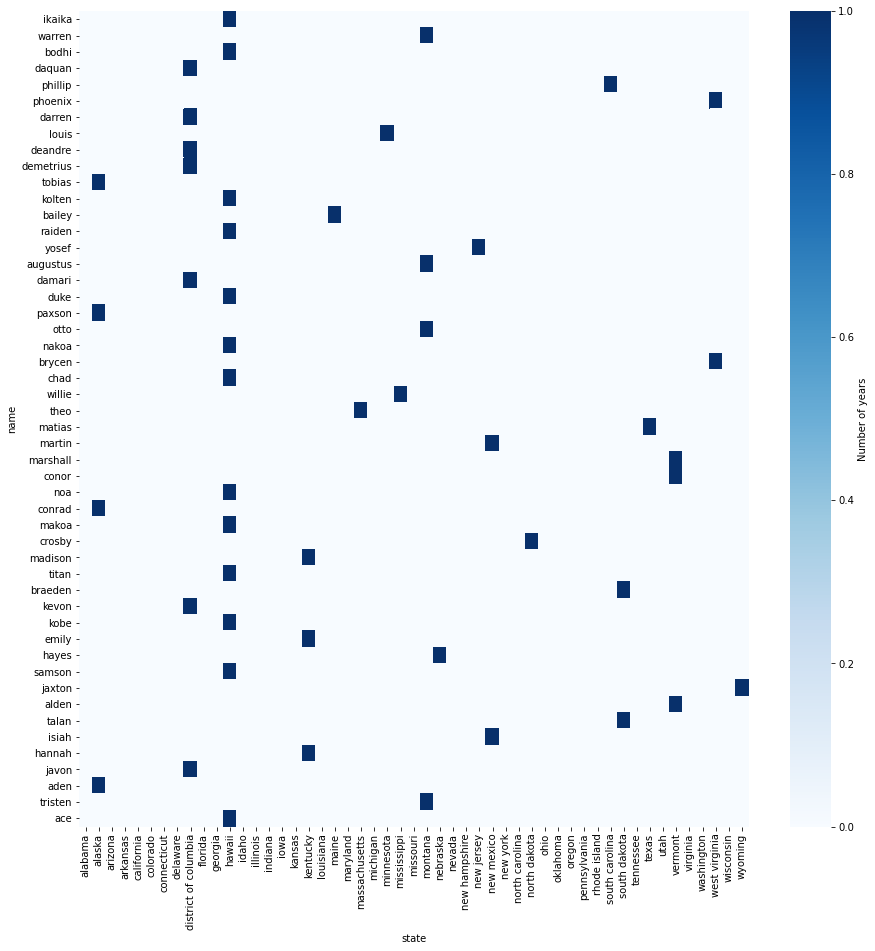

In [21]:
fig,ax = plt.subplots(figsize=[15,15])
#ax.set_title('Top 50 least common male names across the US over the past 19 years')
sns.heatmap(less_common_male_names,cmap='Blues', cbar_kws={'label':'Number of years'})
plt.show()

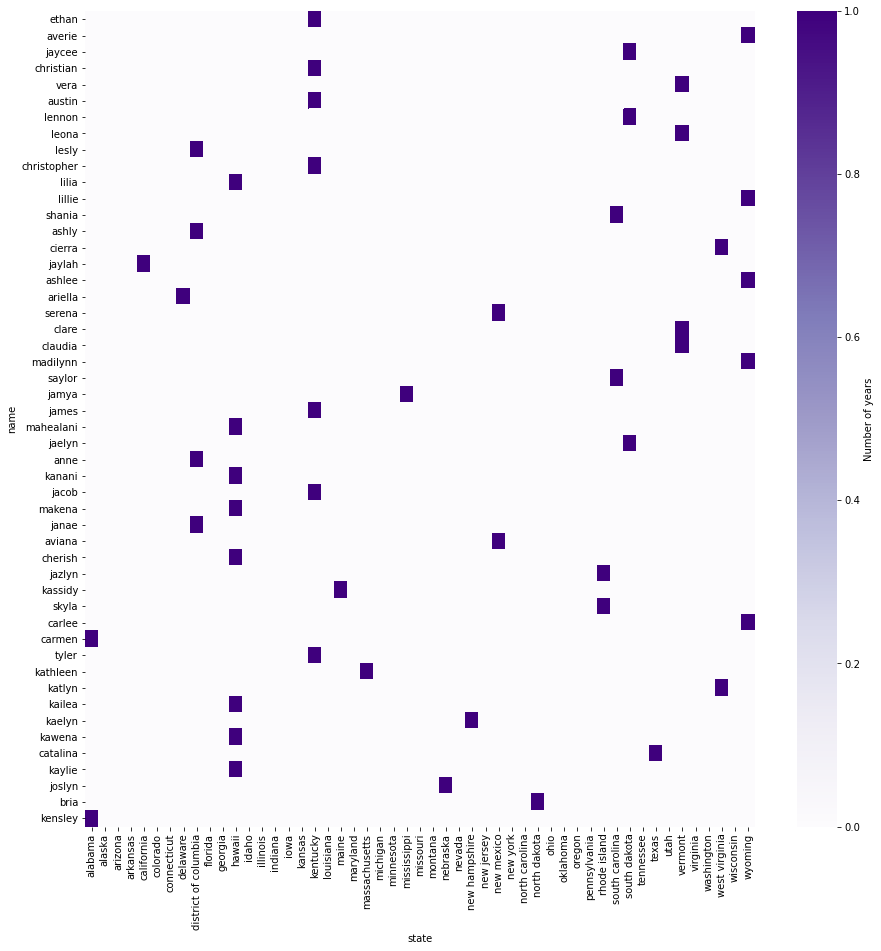

In [22]:
fig,ax = plt.subplots(figsize=[15,15])
#ax.set_title('Top 50 least common female names across the US over the past 19 years')
sns.heatmap(less_common_female_names,cmap='Purples', cbar_kws={'label':'Number of years'})
plt.show()

### 3. Top Unisex names

In [23]:
genders = pd.pivot_table(df, values='chk', index='name', columns='gender')

In [24]:
unisex = genders.loc[(genders.male==1)&(genders.female==1)]

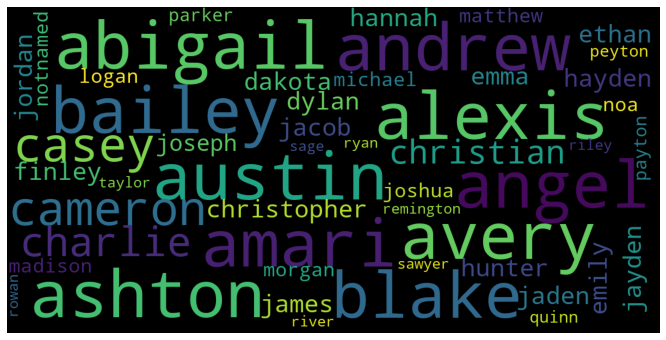

In [25]:
wordcloud = WordCloud(
        background_color = 'black',
        max_font_size = 40,
        max_words = 50, 
        scale = 3,
        random_state = 42,
        contour_width=2
    ).generate_from_frequencies(dict(unisex.female))

fig = plt.figure(1, figsize = (15, 6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### 4. Time series of 2018's top 5 names

In [26]:
names_mean_rank = pd.pivot_table(df, 
                                 index=['gender','name'],
                                 columns='year',
                                 values='rank',
                                 aggfunc=np.mean).round()

In [27]:
# Selecting top 5 names of 2018 in all of US

xx = names_mean_rank.loc['male', 2018].dropna().sort_values().head(5)
xy = names_mean_rank.loc['female', 2018].dropna().sort_values().head(5)

In [28]:
plt.style.use('ggplot')

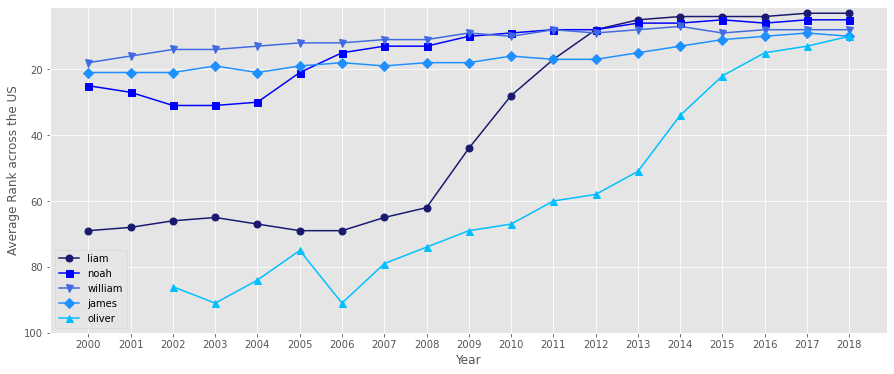

In [29]:
fig,ax = plt.subplots(figsize=[15,6])
markers = ['o','s','v','D','^']
colors = ['midnightblue','blue','royalblue','dodgerblue','deepskyblue']

for x, color, marker in zip(xx.index, colors, markers):
    plotdf = names_mean_rank.loc['male',x]
    plt.plot(plotdf.index, plotdf.values, marker=marker, ms=7, color=color, label=x)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Average Rank across the US')
    plt.xticks(np.arange(2000,2019))
    plt.ylim(100,1)

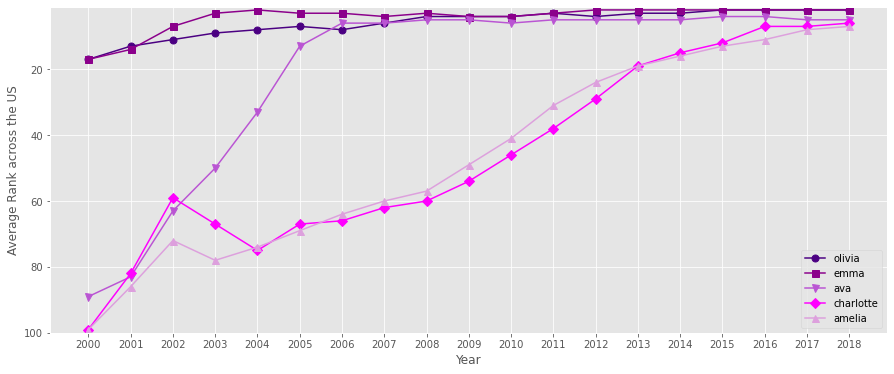

In [30]:
fig,ax = plt.subplots(figsize=[15,6])
markers = ['o','s','v','D','^']
colors = ['indigo','darkmagenta','mediumorchid','magenta','plum']

for y, color, marker in zip(xy.index, colors, markers):
    plotdf = names_mean_rank.loc['female',y]
    plt.plot(plotdf.index, plotdf.values, marker=marker,  ms=7, color=color, label=y)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Average Rank across the US')
    plt.xticks(np.arange(2000,2019))
    plt.ylim(100,1)

### 5. Popularity of top names of 2018 across US

In [31]:
import geopandas as gpd

In [32]:
us_map = gpd.read_file('states.shp')

In [33]:
us_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATE_NAME  51 non-null     object  
 1   DRAWSEQ     51 non-null     int64   
 2   STATE_FIPS  51 non-null     object  
 3   SUB_REGION  51 non-null     object  
 4   STATE_ABBR  51 non-null     object  
 5   geometry    51 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 2.5+ KB


In [34]:
mapdf = us_map[['STATE_NAME','geometry']]

In [35]:
mapdf['STATE_NAME'] = mapdf['STATE_NAME'].apply(lambda x: x.lower())
mapdf['chk'] = np.ones(mapdf.shape[0])

/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


**Helper function to plot the ranks of names across each state in the US**

In [36]:
def rank_plotter(top_names, name, colors, title):    
    # Selecting the states which contain the name of choice
    rankdf = top_names.loc[top_names.name==name][['state','rank']]
    
    #Populating the mapdf with the rank corresponding to the state
    for i in range(rankdf.shape[0]):
        s = rankdf.iloc[i,0]
        r = rankdf.iloc[i,1]
        mapdf.loc[mapdf['STATE_NAME']==s, 'rank_value'] = r

    ## Plotting chloropleth
    fig,ax = plt.subplots(figsize=[15,15])
    
    variable = 'rank_value'
    vmin, vmax = mapdf.rank_value.min(), mapdf.rank_value.max()

    # Create colorbar legend
    cbar_ax = inset_axes(ax,
                        width="5%",  # width = 50% of parent_bbox width
                        height="200%",  # height : 5%
                        bbox_to_anchor=(0.06,0.5,1,0.5),
                        bbox_transform=ax.transAxes,
                        )
    cb = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # Plot the name rank choropleth
    ax.grid(b=None, color='grey', linestyle=':', linewidth=0.5)

    base_map = mapdf.plot(column='chk',
                          color='white',
                          linewidth=0.5, 
                          edgecolor='k', 
                          ax=ax, 
                          alpha=0.5)

    rank_map = mapdf.plot(column=variable, 
                          cmap=colors, 
                          linewidth=0.5, 
                          edgecolor='k', 
                          ax=ax)

    # Add the colorbar to the figure
    fig.colorbar(cb, 
                 cax=cbar_ax, 
                 label='Rank', 
                 orientation='vertical',
                 ticks=np.arange(vmin, vmax+1))
    
    # Set the axes properties
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitutde', fontsize=12)
    ax.tick_params(labelsize=12)

In [37]:
names_18 = df.loc[df['year']==2018]
rank = 5
top_names_18 = names_18.loc[names_18['rank']<=rank]
print('Top 2 male and female names in 2018 \n\n', top_names_18.name.value_counts().head(4))

Top 2 male and female names in 2018 

 olivia    50
emma      49
liam      46
noah      33
Name: name, dtype: int64


/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Onl

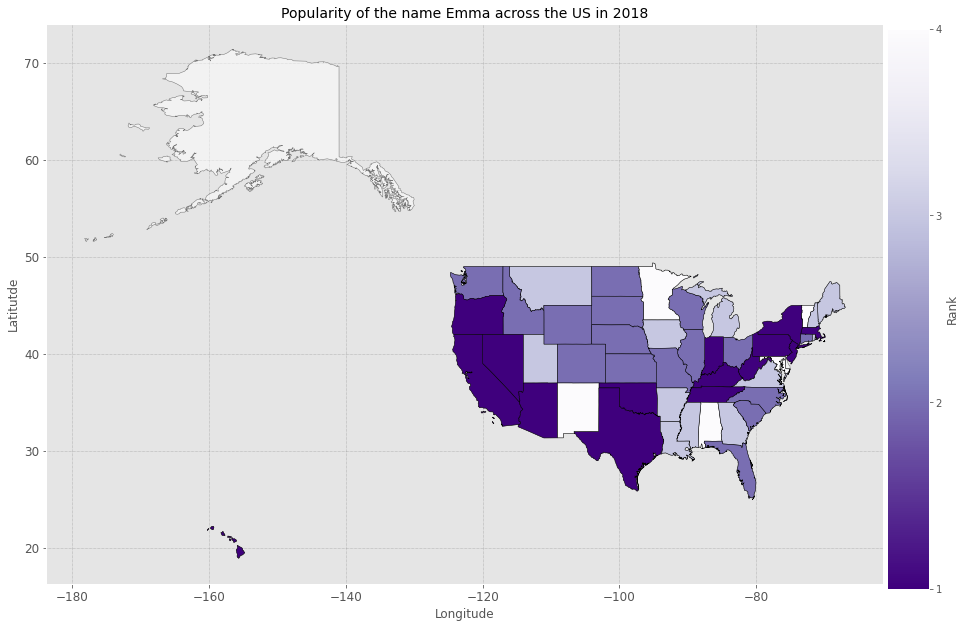

In [38]:
rank_plotter(top_names_18, 'emma', 'Purples_r', 'Popularity of the name Emma across the US in 2018')

/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


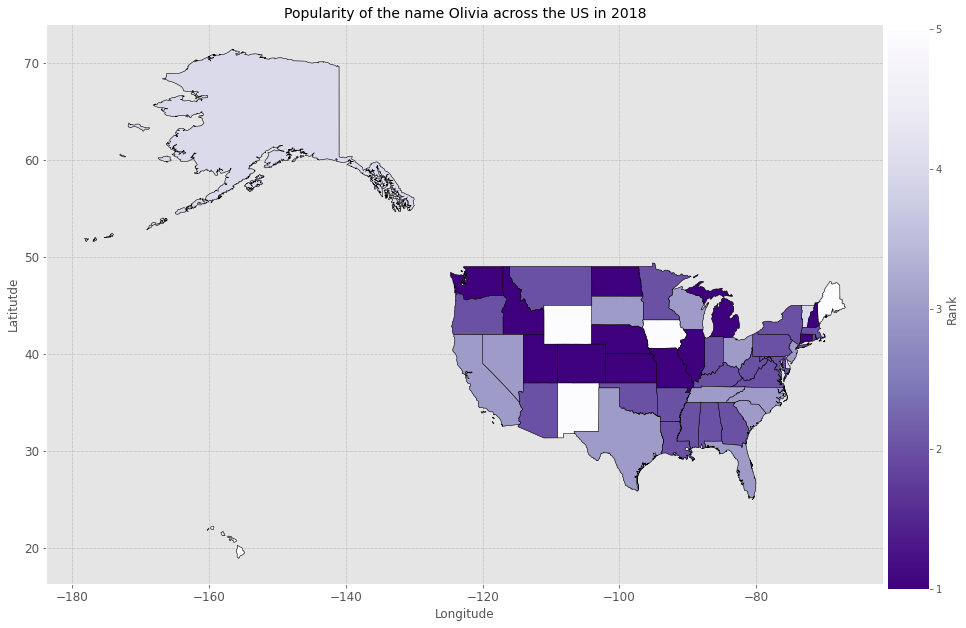

In [39]:
rank_plotter(top_names_18, 'olivia', 'Purples_r', 'Popularity of the name Olivia across the US in 2018')

/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


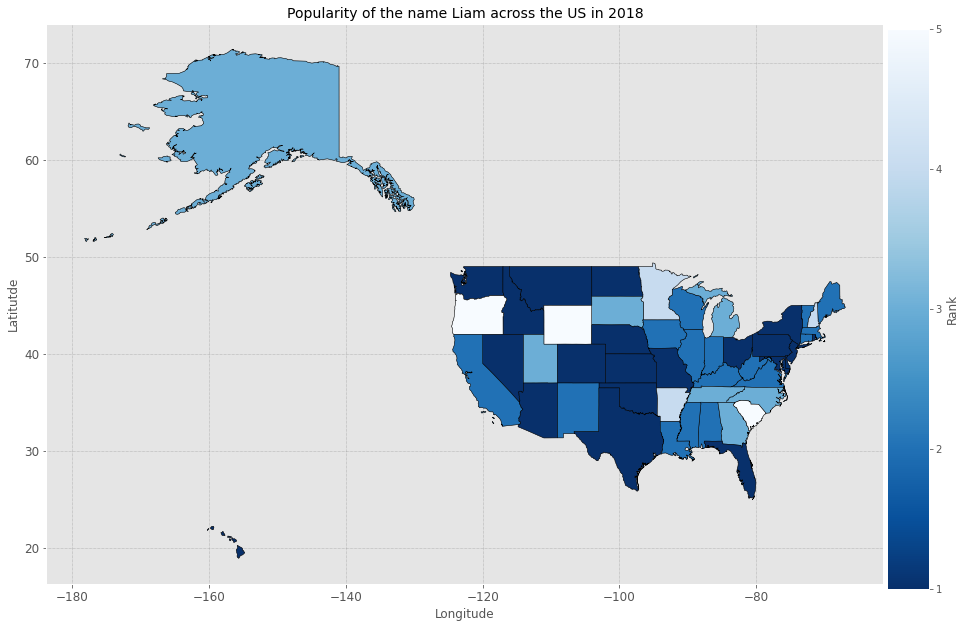

In [40]:
rank_plotter(top_names_18, 'liam', 'Blues_r', 'Popularity of the name Liam across the US in 2018')

/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/anirudhchandra/anaconda3/envs/machine_learning/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


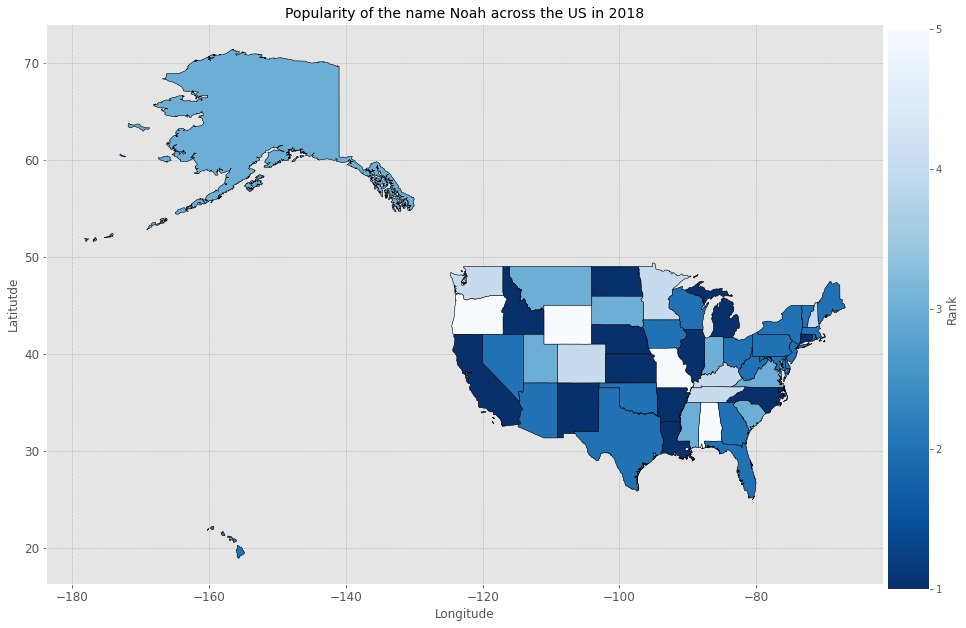

In [41]:
rank_plotter(top_names_18, 'noah', 'Blues_r','Popularity of the name Noah across the US in 2018')